
 Imports & Device Setup



In [15]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Data Loading and Cleaning

In [16]:

def load_and_clean_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'(\w)(\.)', r'\1 .', text)
    text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    return words


Vocabulary Creation

In [17]:

def build_vocab(words):
    vocab = sorted(set(words))
    stoi = {'<PAD>': 0, '<UNK>': 1}
    for idx, w in enumerate(vocab, start=2):
        stoi[w] = idx
    itos = {i: w for w, i in stoi.items()}
    vocab_size = len(stoi)
    return stoi, itos, vocab_size


Dataset Creation

In [18]:
def create_dataset(words, stoi, itos, context_length, show_first_n=20):
    X, Y = [], []
    for i in range(len(words) - context_length):
        context = words[i:i+context_length]
        target = words[i+context_length]
        X.append([stoi.get(w, 1) for w in context])  # 1 = <UNK>
        Y.append(stoi.get(target, 1))

        if i < show_first_n:
            print(f"{' '.join(context)} ---> {target}")

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"\n Dataset created with shapes: X: {X.shape}, Y: {Y.shape}")
    return X, Y


MLP Next-Word Model

In [19]:

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, context_length, hidden1, hidden2=None,
                 activation='relu', dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)

        activation_layer = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU(),
            'leakyrelu': nn.LeakyReLU()
        }.get(activation.lower(), nn.ReLU())

        layers = [nn.Flatten(),
                  nn.Linear(context_length * emb_dim, hidden1),
                  activation_layer,
                  nn.Dropout(dropout)]
        if hidden2:
            layers += [nn.Linear(hidden1, hidden2),
                       activation_layer,
                       nn.Dropout(dropout)]
            layers += [nn.Linear(hidden2, vocab_size)]
        else:
            layers += [nn.Linear(hidden1, vocab_size)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.emb(x)
        return self.mlp(x)

    def get_embeddings(self):
        return self.emb.weight.detach().cpu().numpy()

Visualization Utility

In [20]:
def visualize_embeddings(model, itos, emb_dim=64, n_words=200, title="Embeddings"):
    embeddings = model.get_embeddings()
    if emb_dim != 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        emb_2d = tsne.fit_transform(embeddings[2:2+n_words])
    else:
        emb_2d = embeddings[2:2+n_words]
    plt.figure(figsize=(12, 10))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=12, alpha=0.7)
    for i in range(n_words):
        plt.annotate(itos[i+2], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.7)
    plt.title(title)
    plt.show()

Training Loop

In [21]:
def train_model(model, X, Y, epochs=1000, batch_size=4096, lr=0.003, print_every=100):
    optimizer = optim.AdamW(model.parameters(), lr=lr)  # Using AdamW optimizer
    loss_fn = nn.CrossEntropyLoss()                     # Using cross-entropy loss for classification

    losses = []  # To store average loss for each epoch

    for epoch in range(epochs):
        # Shuffle indices to randomize batches each epoch
        perm = torch.randperm(X.size(0))

        total_loss = 0  # Total loss for the epoch

        for i in range(0, X.size(0), batch_size):
            # Get batch indices
            idx = perm[i:i+batch_size]
            xb = X[idx].to(device)  # Batch input on device
            yb = Y[idx].to(device)  # Batch target on device

            optimizer.zero_grad()   # Reset gradients

            out = model(xb)         # Forward pass: get predictions

            loss = loss_fn(out, yb) # Compute cross-entropy loss

            loss.backward()         # Backward pass: compute gradients

            optimizer.step()        # Update model weights

            # Accumulate loss weighted by batch size for averaging later
            total_loss += loss.item() * xb.size(0)

        # Compute average loss for this epoch
        avg_loss = total_loss / X.size(0)
        losses.append(avg_loss)

        # Optionally print progress
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses  # Return list of epoch-wise average losses for plotting/analysis


Text Generation Utility

In [22]:
def generate_text(model, seed_text, length=30, context_length=5, temperature=1.0):
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)

    # Preprocess seed text: lowercase and split into words
    words_in = seed_text.lower().split()

    # Build initial context:
    # - If the seed text has fewer words than context_length, pad with 0 (<PAD>).
    # - Map words to indices using stoi; use 1 (<UNK>) if word is not found.
    context = (
        [0] * max(0, context_length - len(words_in)) +
        [stoi.get(w, 1) for w in words_in]
    )[-context_length:]

    generated = words_in.copy()  # Start generated sequence with the seed text

    for _ in range(length):
        # Prepare context tensor of shape [1, context_length]
        x = torch.tensor([context], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x).squeeze(0)      # Get raw scores for each vocab word
            logits = logits / temperature      # Adjust randomness

            probs = torch.softmax(logits, dim=-1).cpu()  # Convert to probabilities

        # Sample the next word index from the probability distribution
        next_idx = torch.multinomial(probs, num_samples=1).item()

        # Get the corresponding word (or <UNK> if missing)
        next_word = itos.get(next_idx, "<UNK>")

        # Append generated word to the sequence
        generated.append(next_word)

        # Update context for next prediction by removing the oldest and adding the new word
        context = context[1:] + [next_idx]

    # Return the generated words joined as a string
    return ' '.join(generated)

Saving Utilities

In [23]:
def save_artifacts(model, stoi, itos, emb_dim, context_length,
                   hidden1, hidden2, activation,
                   base_name="nextword_holmes_bundle"):
    """
    Saves:
    - model.state_dict
    - stoi and itos dictionaries
    - config dictionary (architecture hyperparameters)

    into a single .pt file for clean, consistent loading in Streamlit or CLI.
    """
    artifacts = {
        'model_state_dict': model.state_dict(),
        'stoi': stoi,
        'itos': itos,
        'config': {
            'vocab_size': len(stoi) + 1,  # +1 for padding/unknown handling
            'emb_dim': emb_dim,
            'context_length': context_length,
            'hidden1': hidden1,
            'hidden2': hidden2,
            'activation': activation
        }
    }

    save_path = f"{base_name}.pt"
    torch.save(artifacts, save_path)
    print(f"All artifacts saved to {save_path}")


# Shakespeare dataset

In [24]:
# Download Shakespeare dataset
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt -O shakespeare.txt

# Check file size
!ls -lh shakespeare.txt

# Display first 500 characters to inspect
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    print(f.read(500))


--2025-07-08 09:22:37--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   4.36M  2.89MB/s    in 1.5s    

2025-07-08 09:22:40 (2.89 MB/s) - ‘shakespeare.txt’ saved [4573338/4573338]

-rw-r--r-- 1 root root 4.4M May 12  2015 shakespeare.txt
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen

In [25]:
# Load and clean

words = load_and_clean_text('shakespeare.txt')
print(f"Sample cleaned words: {words[:20]}")


# Build vocab
stoi, itos, vocab_size = build_vocab(words)
print(f"Vocab size: {vocab_size}")
print(f"Sample vocab mappings: {list(stoi.items())[:10]}")


# Create dataset
context_length= 5  # can modify for experiments
X, Y = create_dataset(words, stoi, itos, context_length)
print(f"Dataset created with shape X: {X.shape}, Y: {Y.shape}")
print(f"Sample X[0]: {X[0]}, corresponding words: {[itos[idx.item()] for idx in X[0]]}")
print(f"Sample Y[0]: {Y[0]}, corresponding word: {itos[Y[0].item()]}")

Sample cleaned words: ['first', 'citizen', 'before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '.', 'all', 'speak', 'speak', '.', 'first', 'citizen', 'you', 'are', 'all']
Vocab size: 22586
Sample vocab mappings: [('<PAD>', 0), ('<UNK>', 1), ('.', 2), ('...', 3), ('3', 4), ('a', 5), ('aaron', 6), ('abaissiez', 7), ('abandon', 8), ('abandoned', 9)]
first citizen before we proceed ---> any
citizen before we proceed any ---> further
before we proceed any further ---> hear
we proceed any further hear ---> me
proceed any further hear me ---> speak
any further hear me speak ---> .
further hear me speak . ---> all
hear me speak . all ---> speak
me speak . all speak ---> speak
speak . all speak speak ---> .
. all speak speak . ---> first
all speak speak . first ---> citizen
speak speak . first citizen ---> you
speak . first citizen you ---> are
. first citizen you are ---> all
first citizen you are all ---> resolved
citizen you are all resolved ---> rather
you are all resolved r

In [26]:

# Hyperparameters
emb_dim = 32
hidden1 = 1024
hidden2 = 512
activation = 'tanh'
dropout = 0.2

# Instantiate
model = NextWordMLP(vocab_size, emb_dim, context_length, hidden1, hidden2, activation, dropout).to(device)

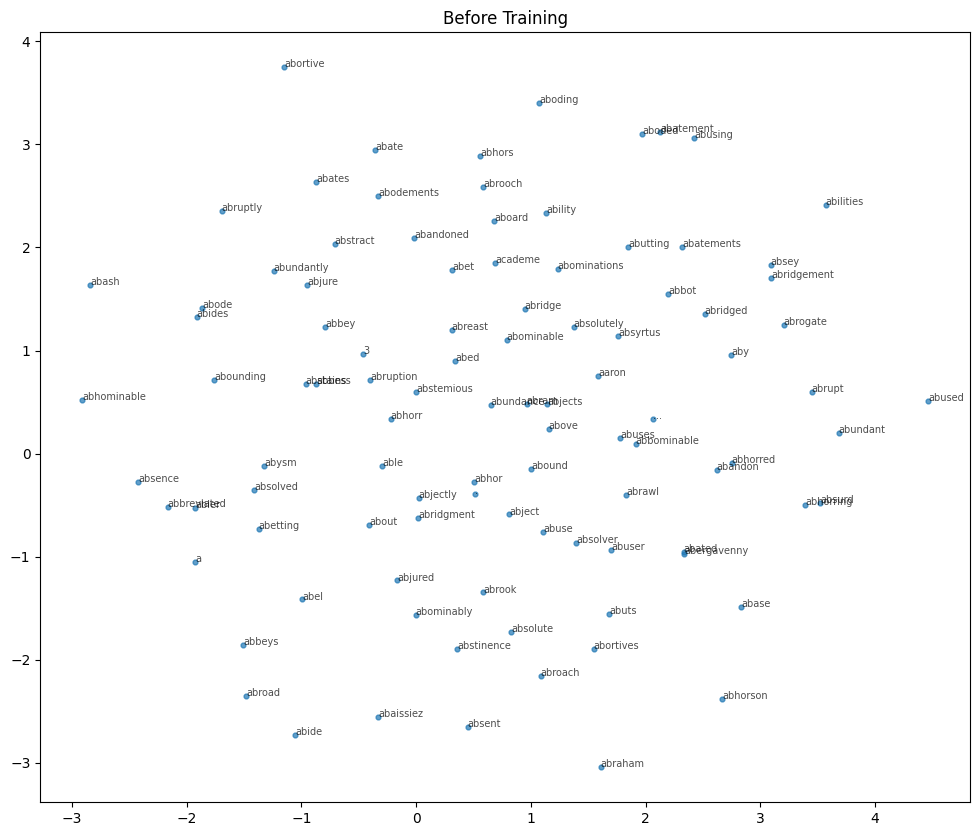

In [27]:

# Visualize Before
visualize_embeddings(model, itos, emb_dim, n_words=100, title="Before Training")


In [28]:
# Train
losses = train_model(model, X, Y, epochs=2000, batch_size=4096, lr=0.002)

Epoch 1/2000, Loss: 6.5684
Epoch 101/2000, Loss: 4.0574
Epoch 201/2000, Loss: 3.9397
Epoch 301/2000, Loss: 3.8840
Epoch 401/2000, Loss: 3.8470


KeyboardInterrupt: 

In [34]:
# Save
save_artifacts(
    model=model,
    stoi=stoi,
    itos=itos,
    emb_dim=emb_dim,
    context_length=context_length,
    hidden1=hidden1,
    hidden2=hidden2,
    activation=activation,
    base_name="Shakespeare_32_tanh_mlp"
)

All artifacts saved to Shakespeare_32_tanh_mlp.pt


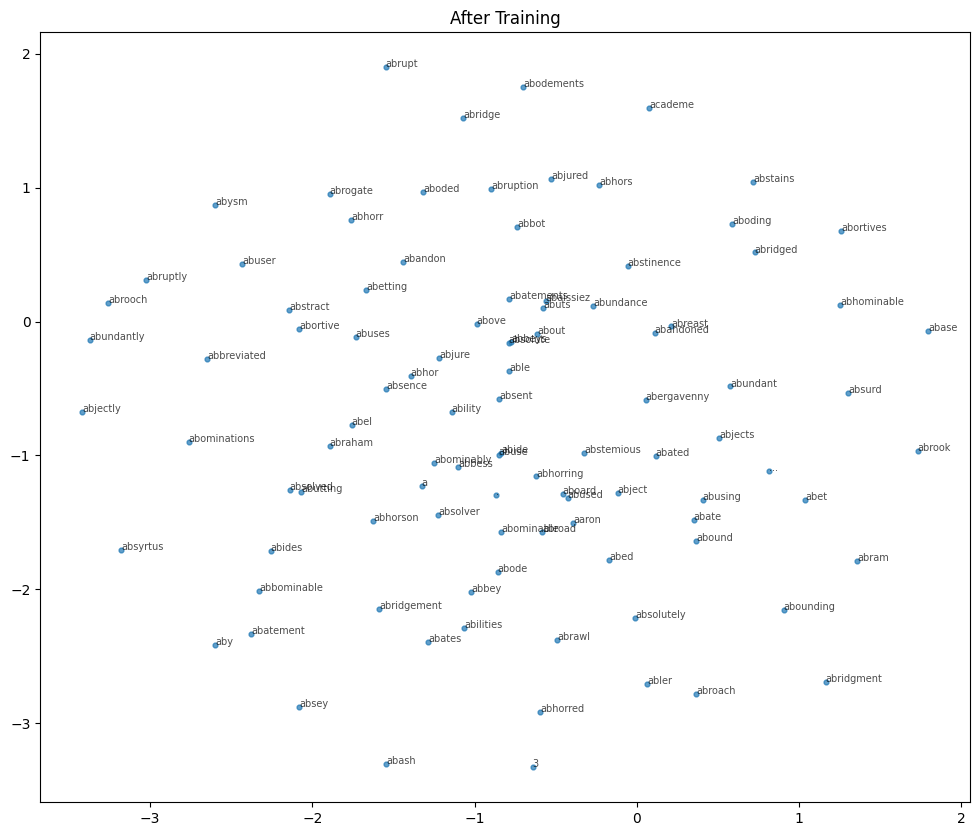

In [30]:
# Visualize After
visualize_embeddings(model, itos, emb_dim, n_words=100, title="After Training")


In [32]:
# Test Generation
seed = "We are accounted poor citizens"
generated = generate_text(model, seed, length=100, context_length=context_length)
print("\n Sample Generated Text:\n", generated)



 Sample Generated Text:
 we are accounted poor citizens . hamlet ay jack of this world pray you . second murderer what is your name of passion is it that s the world goes by high arm out of the sea might blow the man s eye have now to have a thousand death . i shall be give your leave it . king john come cousin why my place . othello truth how little this come so near but it is well lost . them that were the time for some little way then she s dead . edward is there helen my lord hastings o what such
